# To visualize approaches

A simulated dataset is made to vizualize the filtering performed by the clustering approaches and the 

In [148]:
from sklearn.datasets import make_blobs
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar
import seaborn as sns
import matplotlib
%matplotlib inline


from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)

colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']

cmap = ['#F94144', '#F9C74F']

cmap_name = 'my colormap'

c_map = LinearSegmentedColormap.from_list(cmap_name, cmap)

sns.set_palette(colors)

def scatterplot_with_colors(X, y):
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
    colors = {0:colors[0], 1:colors[1], 10: '#484848'}
    f, ax = plt.subplots(1,1) # 1 x 1 array , can also be any other size
    f.set_size_inches(5, 5)
    grouped = df.groupby('label')
    for key, group in grouped:
        label_key = key
        if key == 10:
            label_key = 'deleted samples'
        ax = group.plot(ax=ax, kind='scatter', x='x', y='y', label=label_key, color=colors[key])

    for child in ax.get_children():
        if isinstance(child, matplotlib.text.Text):
            child.set_fontproperties(font)
    for label in ax.get_yticklabels() :
        label.set_fontproperties(font)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(font)
    ax.legend(prop=font)
    plt.show()

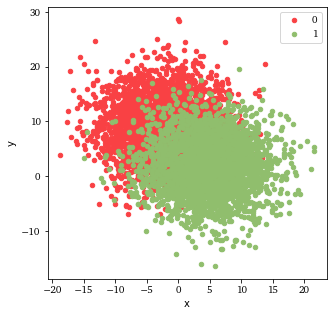

In [152]:
from sklearn.model_selection import train_test_split
import pandas as pd

# generate 2d classification dataset
X, y = make_blobs(n_samples=6000, centers=2, n_features=2, cluster_std = 5, random_state = 42)
# scatter plot, dots colored by class value

X, y = pd.DataFrame(X), pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

f = scatterplot_with_colors(X.values, y.values)

In [153]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')
import utility

sys.path.insert(1, module_path + '/src/models')
import bootstrapped_ensemble_lr_filter as BE_LR_filter


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2

k_range = list(range(1,8))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

clf = KNeighborsClassifier()

clf_dict = {
    'knn': KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1),
    'knnOptimal': clf,
    'nb': GaussianNB()
}

grid_dict = {
    'knnOptimal': grid
}

thresh_list = [2,4,6]
folds_list = [5, 7, 10]


param_dict = BE_LR_filter.hyperparam_search(X_train,y_train, X_val, y_val, clf_dict, grid_dict = grid_dict, thresh_list = thresh_list, folds_list = folds_list)

Testing fold = 5, and threshold = 2
Testing fold = 7, and threshold = 2
Testing fold = 10, and threshold = 2
Testing fold = 5, and threshold = 4
Testing fold = 7, and threshold = 4
Testing fold = 10, and threshold = 4
Testing fold = 7, and threshold = 6
Testing fold = 10, and threshold = 6


In [154]:
X_test = X_test.reset_index(drop = True)

dict_results, indices = BE_LR_filter.compare_classifiers(X_train,y_train, X_test, y_test, clf_dict, param_dict = param_dict)

In [155]:
dict_results

{'knn': {'original': 0.7816666666666666, 'filtered': 0.918918918918919},
 'knnOptimal': {'original': 0.8366666666666667,
  'filtered': 0.9302631578947368},
 'nb': {'original': 0.84, 'filtered': 0.939521800281294}}

In [158]:
import numpy as np
deleted=indices['knnOptimal']
mask=np.full(len(X_test),True,dtype=bool)
mask[deleted]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = 10

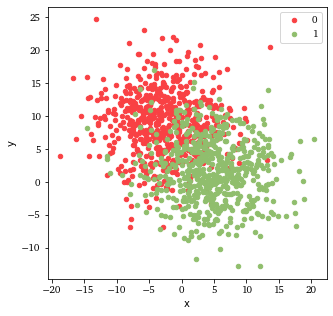

In [159]:
scatterplot_with_colors(X_test.values, y_test.values)

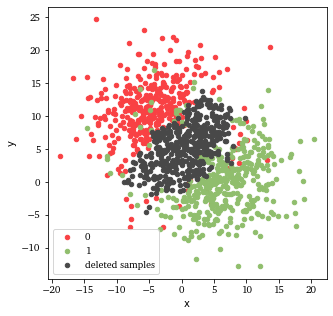

In [160]:
scatterplot_with_colors(X_test.values, new_y_test.values)

# Adding noise

In [161]:
def add_noise_dataset(X, ampl = 1, noise_amount = 6 ):
    '''
    noise amount is inverse, meaning higher noise amout, means less noise... 
    '''
    noise_indices = np.random.RandomState(seed=1).permutation(X.index.tolist())[0:len(X)//noise_amount]
    new_X = X.copy()
    for [idx, row] in new_X.iterrows():
        if idx in noise_indices:
            sig = row
            noise = np.random.RandomState(seed=idx%10).normal(0, ampl, len(sig))
            new_X.iloc[idx] = pd.Series((sig + noise).tolist())
    return new_X , noise_indices

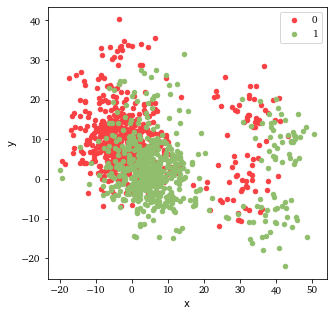

In [162]:
new_X, n_idx= add_noise_dataset(X_test, 20, 3)
scatterplot_with_colors(new_X.values, y_test.values)

In [163]:
dict_results, indices = BE_LR_filter.compare_classifiers(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

deleted=indices['knnOptimal']
mask=np.full(len(new_X),True,dtype=bool)
mask[deleted]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = 10

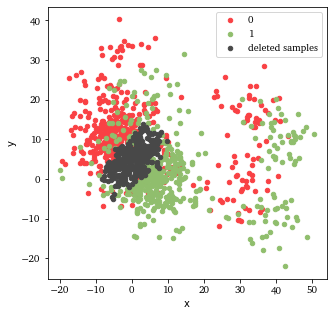

In [164]:
scatterplot_with_colors(new_X.values, new_y_test.values)

Clearly the algorithm is not removing the indices we wish for it to remove, hence this is not an efficient way of removing unwanted data